In [1]:
from utils.train_utils import *
from logic_data.utils import *

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
if __name__ == '__main__':
    is_notebook = False
    try:
        cmd = argparse.ArgumentParser('The testing components of')
        cmd.add_argument('--gpu', default=-1, type=int, help='use id of gpu, -1 if cpu.')
        cmd.add_argument('--train_batch_size', default=128, type=int, help='training batch size')
        cmd.add_argument('--eval_batch_size', default=128, type=int, help='training batch size')
        cmd.add_argument('--lr', default=0.01, type=float, help='learning rate')
        cmd.add_argument('--data_path', required=True, type=str, help='path to the training corpus')
        cmd.add_argument('--train_data_path', required=True, type=str, help='path to the training corpus')
        cmd.add_argument('--test_data_path', required=True, type=str, help='path to the training corpus')
        cmd.add_argument(
            '--encoder_config_path', 
            type=str, help='path to the encoder config'
        )
        cmd.add_argument(
            '--decoder_config_path', 
            type=str, help='path to the decoder config'
        )
        cmd.add_argument('--max_seq_len', default=512, type=int)
        cmd.add_argument('--seed', default=42, type=int)
        cmd.add_argument('--gradient_accumulation_steps', default=1, type=int)
        cmd.add_argument('--output_dir', required=True, type=str, help='save dir')
        cmd.add_argument('--local_rank', default=-1, type=int, help='multi gpu training')
        cmd.add_argument('--epochs', default=10, type=int, help='training epochs')
        cmd.add_argument('--model_path', type=str, required=False, default=None)
        cmd.add_argument('--warm_up', type=float, default=0.1)
        cmd.add_argument('--is_wandb', default=False, action='store_true')
        cmd.add_argument('--log_step', default=10, type=int)
        cmd.add_argument('--valid_steps', default=500, type=int)
        cmd.add_argument('--early_stopping', default=5, type=int)
        cmd.add_argument('--device', default="cuda", type=str, help='')
        cmd.add_argument('--do_prealign_eval', default=False, action='store_true')
        cmd.add_argument('--do_align', default=False, action='store_true')
        cmd.add_argument('--do_eval', default=False, action='store_true')
        cmd.add_argument('--do_test', default=False, action='store_true')
        
        cmd.add_argument('--n_training_program', default=5, type=int)
        cmd.add_argument('--n_fewshot', default=6, type=int)
        cmd.add_argument('--aligning_layer_n', default=0, type=int)
        
        args = cmd.parse_args(sys.argv[1:])
    except:
        is_notebook = True
        parser = argparse.ArgumentParser()
        args = parser.parse_args([])
        args.gpu = 1
        args.eval_batch_size = 64
        args.gradient_accumulation_steps = 2
        args.data_path = "./logic_data"
        args.encoder_config_path = None
        args.decoder_config_path = None
        args.max_seq_len = 512
        args.output_dir = "./results_notebook/"
        args.epochs = 10
        args.warm_up = 0.1
        args.is_wandb = False
        args.log_step = 10
        args.valid_steps = 100 # -1 not do training eval!
        args.early_stopping = 999 # large == never early stop!
        args.device = "cuda:0"
        args.do_prealign_eval = True # do it once at least!
        args.do_align = True
        args.do_eval = True
        args.do_test = True
        # args.model_path = None
        
        # alignment search setting
        args.aligning_layer_n = 0
        args.aligning_basis_n = 600
        args.aligning_var_n = 1
        
        print("Using in a notebook env.")

Using in a notebook env.


usage: The testing components of [-h] [--gpu GPU]
                                 [--train_batch_size TRAIN_BATCH_SIZE]
                                 [--eval_batch_size EVAL_BATCH_SIZE] [--lr LR]
                                 --data_path DATA_PATH --train_data_path
                                 TRAIN_DATA_PATH --test_data_path
                                 TEST_DATA_PATH
                                 [--encoder_config_path ENCODER_CONFIG_PATH]
                                 [--decoder_config_path DECODER_CONFIG_PATH]
                                 [--max_seq_len MAX_SEQ_LEN] [--seed SEED]
                                 [--gradient_accumulation_steps GRADIENT_ACCUMULATION_STEPS]
                                 --output_dir OUTPUT_DIR
                                 [--local_rank LOCAL_RANK] [--epochs EPOCHS]
                                 [--model_path MODEL_PATH] [--warm_up WARM_UP]
                                 [--is_wandb] [--log_step LOG_STEP]
          

In [3]:
results = []

In [4]:
training_clauses = [
    '( c == a ) or ( a != b )',
    '( c != a ) and ( a == b )',
    '( c == a ) or ( b != c )',
    '( c == a ) or ( b == c )',
    '( c != a ) or ( a == b )',
    '( b != a ) and ( b != c )',
    '( c != a ) or ( a != b )',
    '( c == a ) and ( b != c )',
    '( c != a ) and ( b != c )',
    '( c == a ) or ( a == b )',
    '( c != a ) and ( a != b )'
]
align_type = "left_aligment"
level = "l2"
shared_train = True if level == "l1" else False
n_fewshot = 10
n_examples = n_fewshot + 1
n_testing_examples = 1000
saving_models = True

for seed in [42,]: # [42, 66, 77, 88, 99]
    for clauses in training_clauses:
        for n_shot in range(1, n_fewshot+1):
            args.seed = seed
            set_seed(args.seed)
            clauses_no_space = clauses.replace(" ", "")
            print("unrolling for clauses: ", clauses)
            print("seed: ", seed)
            print("current n_shot: ", n_shot)
            # finding model files, it needs to exist on the disk.
            model_name = f"logic_pipeline.model.gpt2.n_rule.11.n_shot.{n_fewshot}.seed.{seed}.clauses.{clauses_no_space}.align.{align_type}.seed.{seed}/model-last"
            args.model_path = os.path.join(args.output_dir, model_name)
            logger = logging.getLogger()
            n_examples = n_shot+1
            aligment_sampled_data = left_aligment_sampler(
                clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
            )
            test_data = {
                "base_input_ids" : aligment_sampled_data[0],
                "base_output_ids" : aligment_sampled_data[1],
                "source_input_ids" : aligment_sampled_data[3],
                "source_output_ids" : aligment_sampled_data[4],
                "counterfacut_output_ids": aligment_sampled_data[6],
                "clauses" : aligment_sampled_data[2],
                "intervention_ids": [0 for i in range(len(aligment_sampled_data[0]))]
            }
            test_dataset = Dataset.from_dict(
                {
                    "input_ids": test_data["base_input_ids"], 
                    "labels": test_data["base_output_ids"],
                    "source_input_ids": test_data["source_input_ids"], 
                    "counterfactual_labels": test_data["counterfacut_output_ids"],
                    "intervention_ids": test_data["intervention_ids"],
                }
            ).with_format("torch")
            test_dataloader = DataLoader(test_dataset, batch_size=args.eval_batch_size)
            
            # Model
            torch.cuda.empty_cache()

            configuration = GPT2Config.from_pretrained(os.path.join(args.data_path, "decoder_config.json"))

            if "logic" in model_name:
                arity = 3
            start_idx = 1 + (arity + 4) * int(n_shot)
            end_idx = start_idx + (arity+1)
            alignment_config = {
                "layer" : args.aligning_layer_n,
                "token_range" : [start_idx, end_idx] # this is kind of fixed?
            }
            if args.aligning_var_n == 1:
                intervention_config = {
                    0: [[0, args.aligning_basis_n]]
                }
            elif args.aligning_var_n == 2:
                pass
            logging.info(f"intervention_config = {intervention_config}")
            logging.info(f"alignment_config = {alignment_config}")

            model = AlignableGPT2LMHeadModel(configuration, alignment_config=alignment_config)
            if args.model_path is not None:
                logging.info("Loading pretrained model.")
                raw_weights = torch.load(os.path.join(args.model_path, 'pytorch_model.bin'))
                model.load_state_dict(raw_weights, strict=False)

            # we need to set off gradients!
            for name, param in model.named_parameters():
                param.requires_grad = False

            device = torch.device(args.device)
            if "cuda:" not in args.device:
                n_gpu = torch.cuda.device_count()
                logging.info(f'__Number CUDA Devices: {n_gpu}')
            else:
                n_gpu = 1
                logging.info(f'__Number CUDA Devices: {n_gpu}')

            if n_gpu > 1:
                model = torch.nn.DataParallel(model)
            _ = model.to(device)

            aligner = LogicSolverAligner(
                model, device=device, 
                logger=logger,
                is_master=True, 
                n_gpu=n_gpu,
                is_wandb=args.is_wandb, 
                model_name=model_name,
                intervention_config=intervention_config
            )
            num_params = count_parameters(model)
            logging.info(f'Number of {model_name} model params: {num_params}')
        
            # task performance with unrolling.
            total_count = 0
            correct_count = 0
            _ = model.eval()
            epoch_iterator = tqdm(test_dataloader, desc="Iteration", position=0, leave=True)
            for step, inputs in enumerate(epoch_iterator):
                input_ids = inputs['input_ids'].to(device)
                labels = inputs['labels'].to(device)
                outputs = model(input_ids=input_ids)
                actual_test_labels = labels[:, -3]
                pred_test_labels = torch.argmax(outputs.logits[:, -4], dim=-1)
                correct_labels = (actual_test_labels==pred_test_labels)

                total_count += len(correct_labels)
                correct_count += correct_labels.sum().tolist()

                current_acc = round(correct_count/total_count, 2)
                epoch_iterator.set_postfix({'acc': current_acc})
            task_acc = round(correct_count/total_count, 2)

            # iia with unrolling.
            total_count = 0
            correct_count = 0
            aligner.model.eval()
            epoch_iterator = tqdm(test_dataloader, desc="Iteration", position=0, leave=True)
            for step, inputs in enumerate(epoch_iterator):
                for k, v in inputs.items():
                    if v is not None and isinstance(v, torch.Tensor):
                        inputs[k] = v.to(device)
                if aligner.preload_intervention_corr is not None:
                    intervention_corr = aligner.preload_intervention_corr.expand(
                        inputs['input_ids'].shape[0],-1
                    ).to(device)
                else:
                    assert False # not implemented

                # aligning forward!
                source_hidden_states = aligner.model(
                   input_ids=inputs['source_input_ids']
                ).rotated_hidden_states
                outputs = aligner.model(
                    input_ids=inputs['input_ids'],
                    source_hidden_states=source_hidden_states,
                    intervention_corr=intervention_corr,
                    labels=inputs['counterfactual_labels']
                )

                actual_test_labels = inputs['counterfactual_labels'][:, -3]
                pred_test_labels = torch.argmax(outputs.logits[:, -4], dim=-1)
                correct_labels = (actual_test_labels==pred_test_labels)

                total_count += len(correct_labels)
                correct_count += correct_labels.sum().tolist()

                current_acc = round(correct_count/total_count, 2)
                epoch_iterator.set_postfix({'acc': current_acc})
            iia_acc = round(correct_count/total_count, 2)

            results += [[clauses, n_shot, seed, task_acc, iia_acc]]

unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6427.02it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.33it/s, acc=0.76]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13565.94it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.56it/s, acc=0.83]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10451.01it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.14it/s, acc=0.86]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8394.97it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.42it/s, acc=0.87]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7229.84it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.90it/s, acc=0.93]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6237.53it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.24it/s, acc=0.94]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5512.60it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s, acc=0.97]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4929.68it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.05it/s, acc=0.98]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4452.83it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.03it/s, acc=0.79]


unrolling for clauses:  ( c == a ) or ( a != b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4112.92it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.90it/s, acc=0.99]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20539.77it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s, acc=0.6]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13869.09it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.97it/s, acc=0.78]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10844.92it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.00it/s, acc=0.86]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8708.65it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.33it/s, acc=0.91]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7346.47it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.40it/s, acc=0.95]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6413.75it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.80it/s, acc=0.96]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5586.39it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.07it/s, acc=0.98]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4973.60it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s, acc=0.98]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4475.49it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.83it/s, acc=0.81]


unrolling for clauses:  ( c != a ) and ( a == b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4085.10it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.34it/s, acc=0.99]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20732.37it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.79it/s, acc=0.75]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13487.07it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.91it/s, acc=0.74]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10819.99it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.47it/s, acc=0.8]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8750.07it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.20it/s, acc=0.83]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7447.97it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.47it/s, acc=0.88]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6391.86it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.81it/s, acc=0.93]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5576.85it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.13it/s, acc=0.96]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4964.70it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.45it/s, acc=0.95]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4504.67it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.97it/s, acc=0.77]


unrolling for clauses:  ( c == a ) or ( b != c )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4107.58it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.41it/s, acc=0.98]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20005.17it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.88it/s, acc=0.59]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13931.65it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.10it/s, acc=0.73]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10798.29it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.11it/s, acc=0.84]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8765.45it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.68it/s, acc=0.87]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7322.32it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.33it/s, acc=0.92]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6260.63it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.82it/s, acc=0.97]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5591.88it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.99it/s, acc=0.97]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4924.26it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s, acc=0.97]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4455.80it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.93it/s, acc=0.73]


unrolling for clauses:  ( c == a ) or ( b == c )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4116.03it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(b==c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.39it/s, acc=0.99]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20649.80it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.88it/s, acc=0.75]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14121.33it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s, acc=0.79]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10441.33it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.10it/s, acc=0.85]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8590.61it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.24it/s, acc=0.9]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7387.23it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.96it/s, acc=0.95]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6446.02it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.81it/s, acc=0.95]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5582.05it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s, acc=0.98]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4975.90it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s, acc=0.99]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4465.62it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.98it/s, acc=0.76]


unrolling for clauses:  ( c != a ) or ( a == b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4102.22it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.34it/s, acc=0.99]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20725.82it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.89it/s, acc=0.66]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14150.78it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.86it/s, acc=0.73]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10659.24it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s, acc=0.83]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8928.76it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.31it/s, acc=0.84]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7477.08it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.57it/s, acc=0.92]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6525.42it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.19it/s, acc=0.95]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3405.18it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.62it/s, acc=0.94]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4975.02it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.39it/s, acc=0.98]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4545.33it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.97it/s, acc=0.7]


unrolling for clauses:  ( b != a ) and ( b != c )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4164.49it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(b!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.44it/s, acc=0.99]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20634.66it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.88it/s, acc=0.76]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14298.49it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.01it/s, acc=0.73]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10757.47it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.11it/s, acc=0.8]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8896.43it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.25it/s, acc=0.83]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7417.04it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.50it/s, acc=0.91]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6527.76it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.82it/s, acc=0.94]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5582.17it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.08it/s, acc=0.96]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5040.32it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s, acc=0.97]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4526.51it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.90it/s, acc=0.65]


unrolling for clauses:  ( c != a ) or ( a != b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4098.00it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)or(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.34it/s, acc=0.98]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20104.32it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.72it/s, acc=0.57]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14026.74it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.73it/s, acc=0.74]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10451.66it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.92it/s, acc=0.84]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8690.03it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.06it/s, acc=0.88]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7305.05it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.46it/s, acc=0.92]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6354.99it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.78it/s, acc=0.95]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5558.19it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s, acc=0.96]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4924.39it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.31it/s, acc=0.97]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4413.83it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.57it/s, acc=0.72]


unrolling for clauses:  ( c == a ) and ( b != c )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4082.06it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.34it/s, acc=0.99]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 21085.38it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.76it/s, acc=0.7]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 14360.02it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.97it/s, acc=0.76]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10991.10it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.09it/s, acc=0.83]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8873.40it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.23it/s, acc=0.83]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7436.93it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.50it/s, acc=0.89]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6493.74it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.85it/s, acc=0.94]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5588.96it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.20it/s, acc=0.95]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5035.28it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.85it/s, acc=0.95]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4416.08it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.47it/s, acc=0.72]


unrolling for clauses:  ( c != a ) and ( b != c )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4064.06it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(b!=c).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51it/s, acc=0.98]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20483.30it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 19.03it/s, acc=0.67]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13903.85it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.98it/s, acc=0.76]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10866.10it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s, acc=0.85]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8715.07it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.24it/s, acc=0.86]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7355.78it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.51it/s, acc=0.95]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6444.55it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.77it/s, acc=0.96]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5461.85it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.15it/s, acc=0.98]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4978.66it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s, acc=0.99]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4454.89it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.90it/s, acc=0.84]


unrolling for clauses:  ( c == a ) or ( a == b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4095.94it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c==a)or(a==b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.45it/s, acc=0.99]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 20740.37it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [8, 12]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.51it/s, acc=0.59]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13820.33it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [15, 19]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.84it/s, acc=0.72]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10823.81it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [22, 26]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.11it/s, acc=0.8]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8787.38it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [29, 33]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.23it/s, acc=0.83]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7560.25it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [36, 40]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.47it/s, acc=0.93]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6401.09it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [43, 47]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.83it/s, acc=0.96]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5620.24it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [50, 54]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.14it/s, acc=0.97]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5035.77it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [57, 61]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.37it/s, acc=0.99]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4525.28it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [64, 68]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.87it/s, acc=0.85]


unrolling for clauses:  ( c != a ) and ( a != b )
seed:  42
current n_shot:  10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4153.63it/s]
INFO:root:intervention_config = {0: [[0, 600]]}
INFO:root:alignment_config = {'layer': 0, 'token_range': [71, 75]}
INFO:root:Loading pretrained model.
INFO:root:__Number CUDA Devices: 1
INFO:root:Number of logic_pipeline.model.gpt2.n_rule.11.n_shot.10.seed.42.clauses.(c!=a)and(a!=b).align.left_aligment.seed.42/model-last model params: 0
Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.28it/s, acc=1]


In [5]:
result_df = pd.DataFrame(results, columns = [
    'clauses', 'n_shot', 'seed', 'task_acc', 'iit_acc'
])
result_df = result_df.groupby(
    ['n_shot'], as_index=False
).mean()[
    ['n_shot', 'task_acc', 'iit_acc']
]
plot_df = result_df[['n_shot', 'task_acc', 'iit_acc']].melt('n_shot', var_name='cols',  value_name='acc')

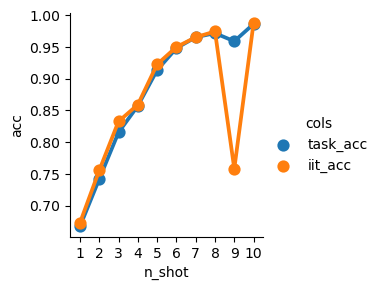

In [6]:
ax = sns.catplot(
    x="n_shot", y="acc", hue='cols', 
    data=plot_df, kind='point', height=3
)

### Zero-shot representation transfer

In [ ]:
args.test_data_path = \
    "./logic_data/left_aligment_test_data.l1.clauses.(c!=b)and(c!=a).pkl"
test_data = pickle.load(open(args.test_data_path, 'rb'))

test_dataset = Dataset.from_dict(
    {
        "input_ids": test_data["base_input_ids"], 
        "labels": test_data["base_output_ids"],
        "source_input_ids": test_data["source_input_ids"], 
        "counterfactual_labels": test_data["counterfacut_output_ids"],
        "intervention_ids": test_data["intervention_ids"],
    }
).with_format("torch")
test_dataloader = DataLoader(test_dataset, batch_size=args.eval_batch_size)

# Model
torch.cuda.empty_cache()

total_count = 0
correct_count = 0
if args.do_test:
    aligner.model.eval()
    epoch_iterator = tqdm(test_dataloader, desc="Iteration", position=0, leave=True)
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)
        if aligner.preload_intervention_corr is not None:
            intervention_corr = aligner.preload_intervention_corr.expand(
                inputs['input_ids'].shape[0],-1
            ).to(device)
        else:
            assert False # not implemented

        # aligning forward!
        source_hidden_states = aligner.model(
           input_ids=inputs['source_input_ids']
        ).rotated_hidden_states
        outputs = aligner.model(
            input_ids=inputs['input_ids'],
            source_hidden_states=source_hidden_states,
            intervention_corr=intervention_corr,
            labels=inputs['counterfactual_labels']
        )

        actual_test_labels = inputs['counterfactual_labels'][:, -3]
        pred_test_labels = torch.argmax(outputs.logits[:, -4], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()

        current_acc = round(correct_count/total_count, 2)
        epoch_iterator.set_postfix({'acc': current_acc})